# Import

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append('src/fast_ica')
from fast_ica import Fast_ICA
from sklearn.decomposition import FastICA as sk_FastICA

sys.path.append('src/denoising')
from image_preprocessing import ImagePreprocessing
from metrics import Metrics

%reload_ext autoreload
%autoreload 2

# Hyperparameters

In [2]:
NB_SAMPLES    = 1000
NB_COMPONENTS = 2
NB_FEATURES   = 2

# Smooth signals

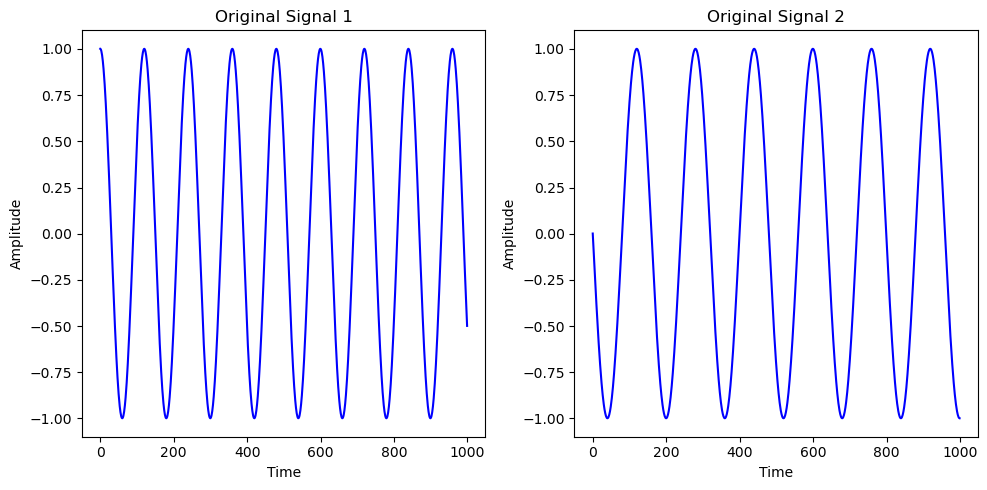

In [11]:
S = np.zeros((NB_FEATURES, NB_SAMPLES))
for k in range(NB_FEATURES):
    S[k] = np.cos(2*np.pi*np.linspace(0, 100, NB_SAMPLES)/np.random.randint(low=10, high=20) + np.random.binomial(p=0.5, n=1) * np.pi / 2) + 1e-3

plt.subplots(1, NB_FEATURES, figsize=(10, 5))

for k in range(NB_FEATURES):
    plt.subplot(1, NB_FEATURES, k+1)
    plt.plot(S[k], color='blue')
    plt.title('Original Signal {}'.format(k+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [12]:
S.shape

(2, 1000)

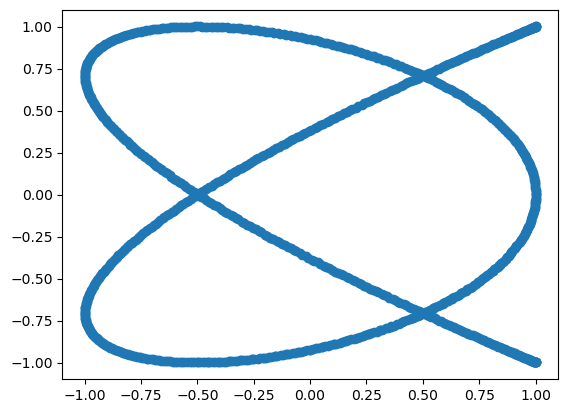

In [13]:
plt.scatter(S[0], S[1])

# Mixed Signals

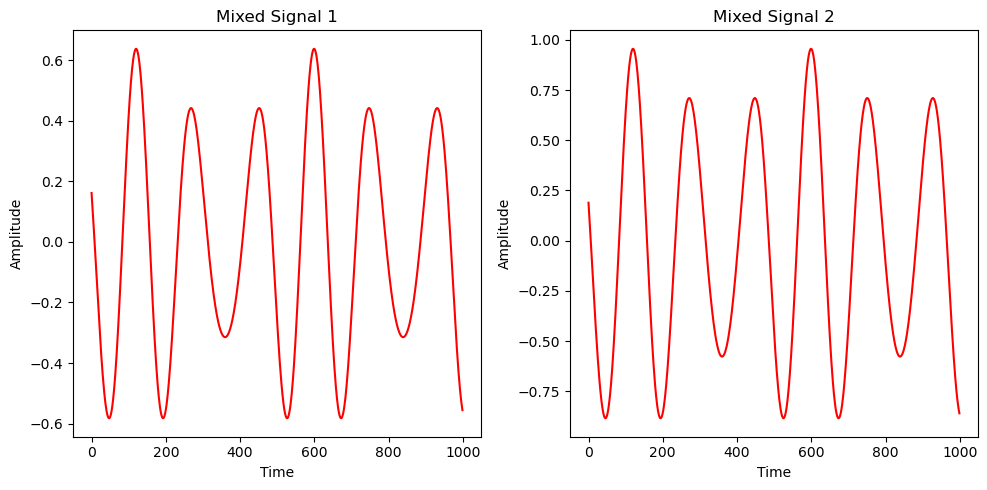

In [14]:
A = np.random.random(size=(NB_COMPONENTS, NB_FEATURES))
X = A @ S

plt.subplots(1, NB_COMPONENTS, figsize=(10, 5))

for k in range(NB_COMPONENTS):
    plt.subplot(1, NB_COMPONENTS, k+1)
    plt.plot(X[k], color='red')
    plt.title('Mixed Signal {}'.format(k+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

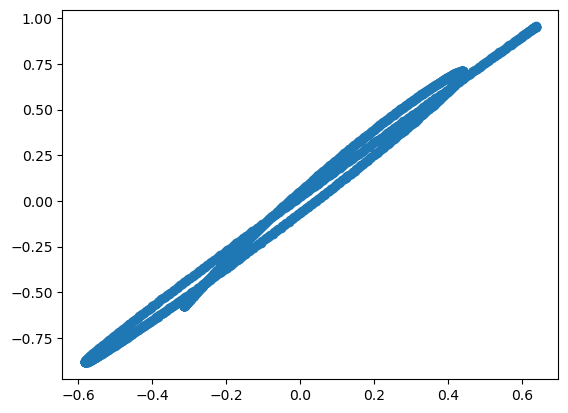

In [15]:
plt.scatter(X[0], X[1])

# Implement ICA algorithm

In [27]:
# %%timeit
ica = Fast_ICA(n_components=2, whiten_method="eigh")
S_ = ica.fit_transform(X, method='parallel')
S_

array([[ 1.3967567 ,  1.39447832,  1.38830489, ..., -0.60949722,
        -0.67670368, -0.74212646],
       [ 0.04073102, -0.01489052, -0.07043736, ..., -1.37585378,
        -1.37932556, -1.38060741]])

In [28]:
ica = sk_FastICA(n_components=NB_COMPONENTS)
S_scikit = ica.fit_transform(X.T)
S_scikit

[[ 0.02573665  0.04052464]
 [ 1.0558545  -0.67055884]]


array([[ 1.39693653, -0.03400932],
       [ 1.39439052,  0.02160061],
       [ 1.38794987,  0.0771171 ],
       ...,
       [-0.6161108 ,  1.37290494],
       [-0.68333319,  1.37605327],
       [-0.74876139,  1.37702029]])

In [29]:
# %%timeit
# ica = Fast_ICA(n_components=NB_FEATURES, func='exp')
# S_ = ica.fit_transform(X, method='parallel')
# S_

In [30]:
# ica = Fast_ICA(n_components=NB_FEATURES)
# S_ = ica.fit_transform(X, method='parallel')
# S_

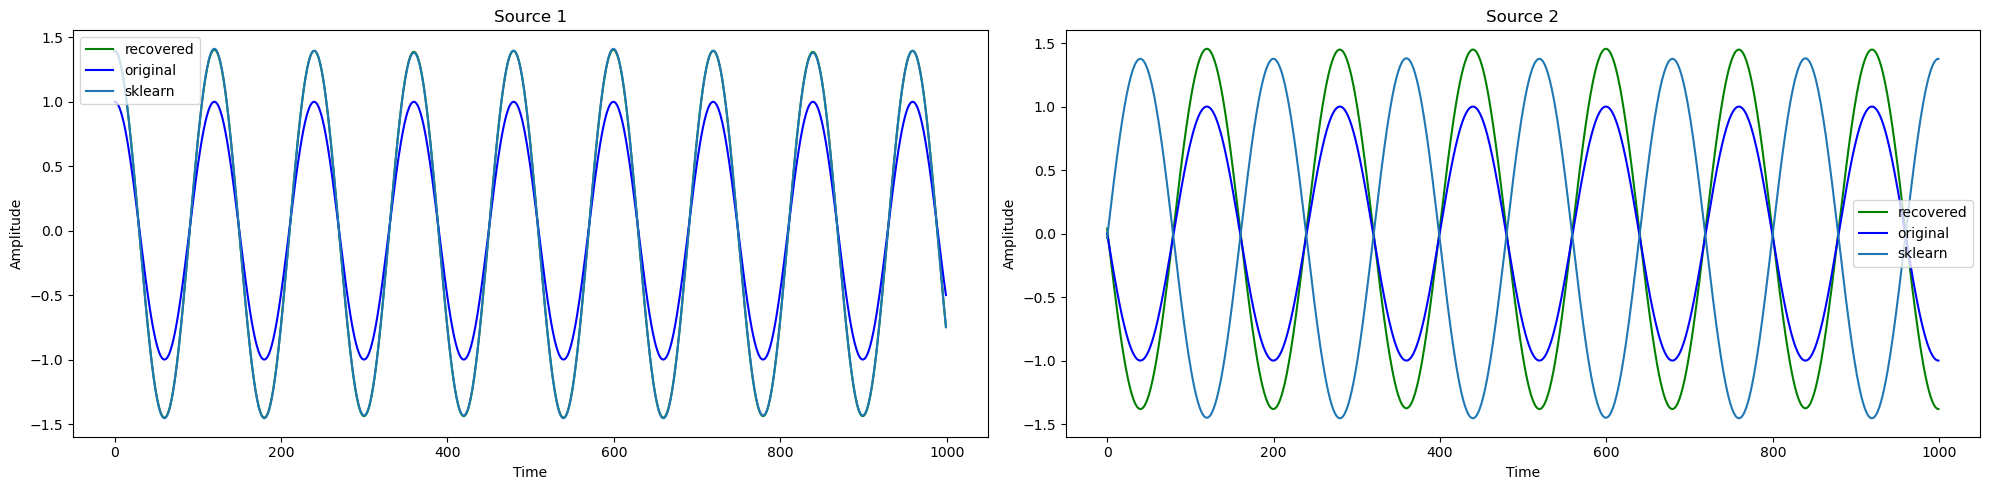

In [31]:
plt.subplots(1, NB_COMPONENTS, figsize=(20,5))

for k in range(NB_FEATURES):
    plt.subplot(1, NB_FEATURES, k+1)
    plt.plot(S_[k], color='green', label="recovered")
    plt.plot(S[k], color='blue', label="original")
    plt.plot(S_scikit[:, k], label='sklearn')
    plt.title('Source {}'.format(k+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()

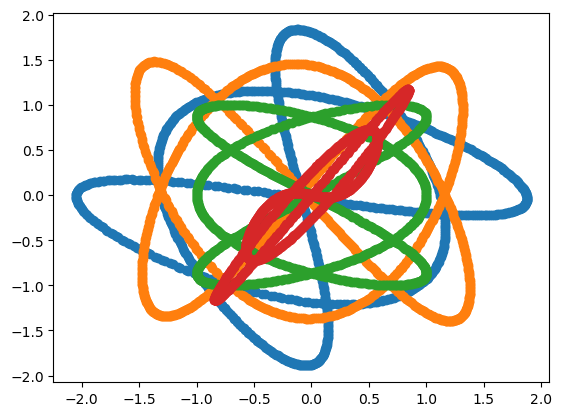

In [15]:
plt.scatter(S_[0], S_[1])
plt.scatter(S_scikit[:, 0], S_scikit[:, 1])
plt.scatter(S[0], S[1])
plt.scatter(X[0], X[1])

In [516]:
# from dtw import dtw
# matrix_dtw = np.zeros((NB_COMPONENTS, NB_COMPONENTS))

# for i in range(NB_COMPONENTS):
#     for j in range(NB_COMPONENTS):
#         matrix_dtw[i, j] = dtw(S[i], S_[j]).distance

# matrix_dtw

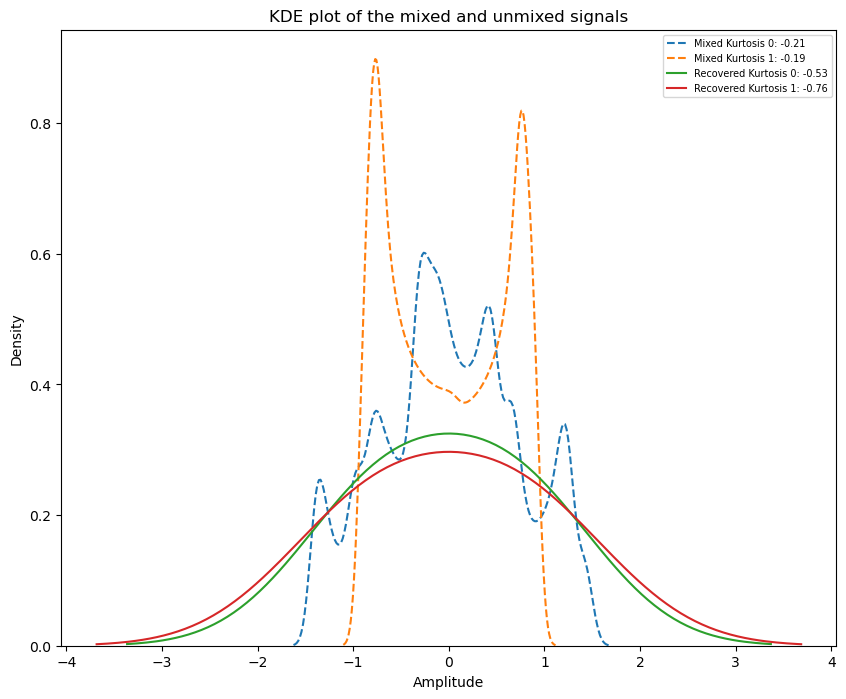

In [517]:
import seaborn as sns

def kurtosis(X):
    return np.mean(X**4, axis=1) - 3 * np.mean(X**2, axis=1)**2

plt.figure(figsize=(10, 8))
plt.title('KDE plot of the mixed and unmixed signals')

for i in range(NB_COMPONENTS):
    sns.kdeplot(X[i], ls='--', label=f"Mixed Kurtosis {i}: {kurtosis(X)[i]:.2f}")

for i in range(NB_FEATURES):
    sns.kdeplot(S_[i], label=f"Recovered Kurtosis {i}: {kurtosis(S_)[i]:.2f}")

plt.tick_params(labelsize=10)
plt.legend(loc='best', fontsize=7)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.show()

# Images

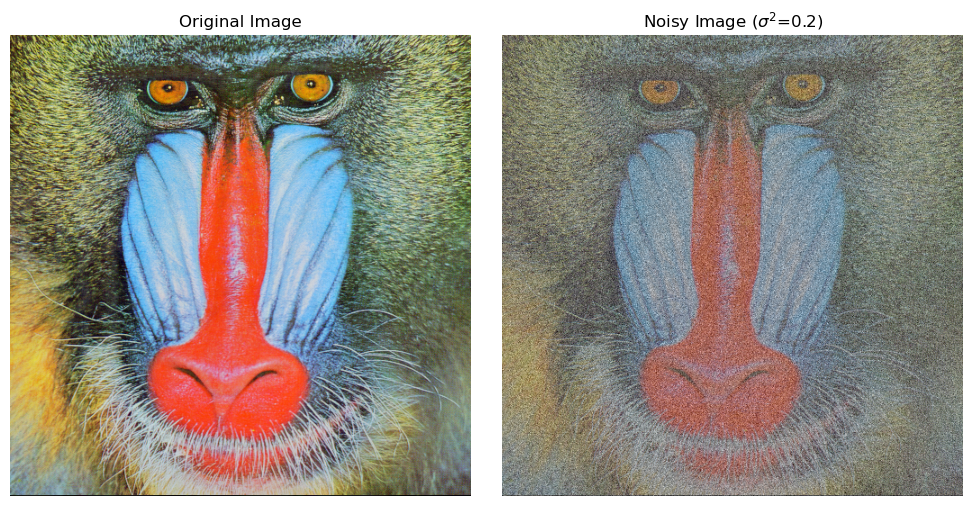

In [518]:
plt.subplots(1, 2, figsize=(10, 5))
sigma = 0.2

plt.subplot(1, 2, 1)
plt.imshow(ImagePreprocessing.noising('baboon.png', 0), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ImagePreprocessing.noising('baboon.png', sigma), cmap='gray')
plt.title(rf'Noisy Image ($\sigma^2$={sigma})')
plt.axis('off')

plt.tight_layout()
plt.show()

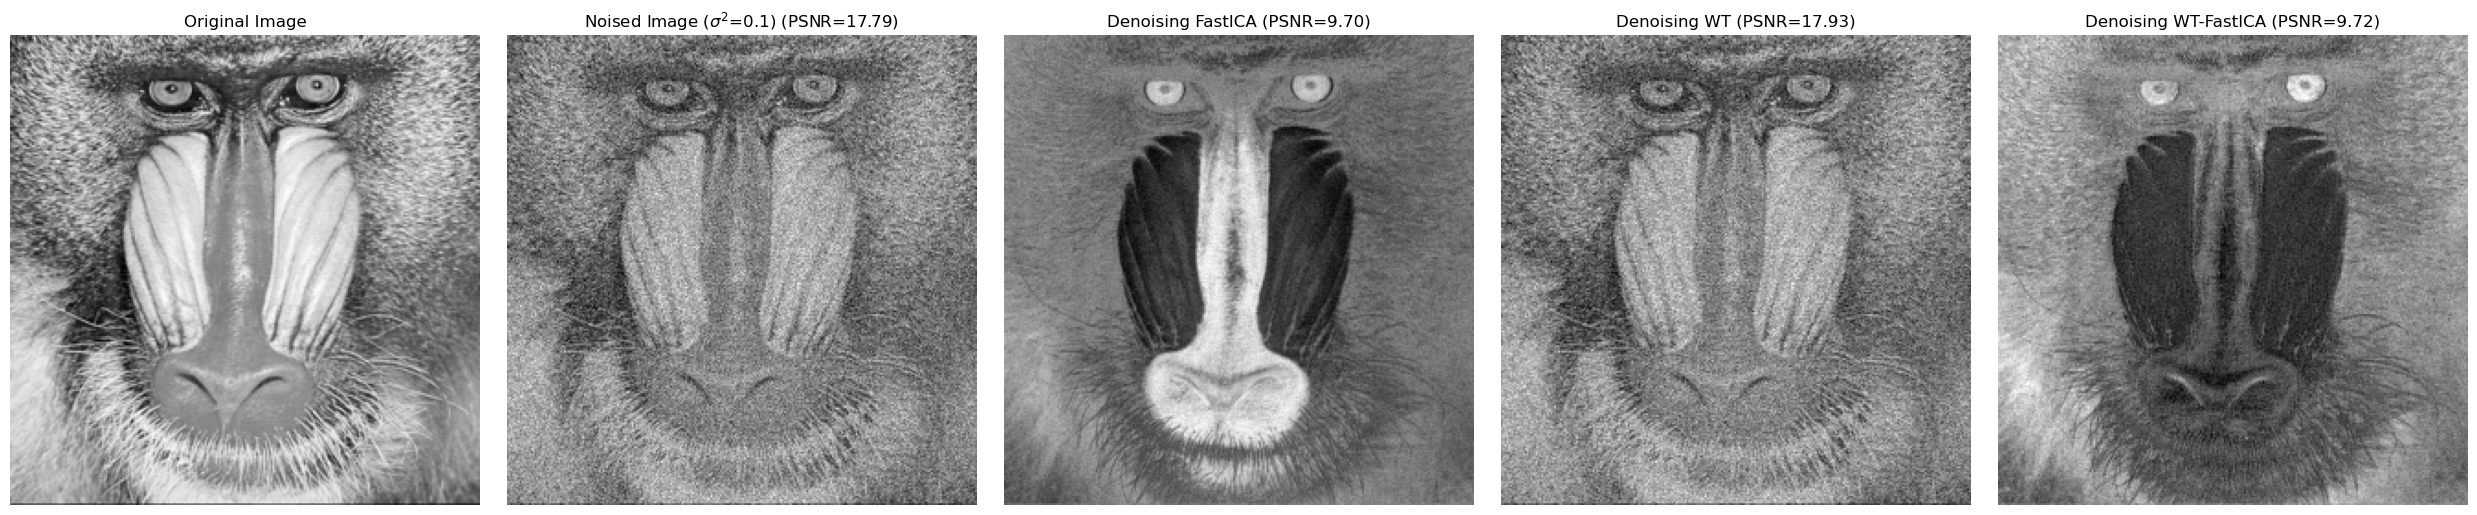

In [451]:
SIGMA = 0.1
WIDTH, HEIGHT = 256, 256
CHANNELS = 3
SOFT_THRESHOLD = 0.02

# Load the original image
I_original = Image.open('images/baboon.png').resize((WIDTH, HEIGHT))
I_original = np.array(I_original)
I_original_gray = ImagePreprocessing.gray(I_original)

# Noise the image
I_noisy = ImagePreprocessing.noising('baboon.png', SIGMA, WIDTH, HEIGHT)
I_noisy_gray = ImagePreprocessing.gray(I_noisy)

# Denoise the image with FastICA
I_reconstructed = sk_FastICA(n_components=3, max_iter=10_000, tol=1e-8).fit_transform(I_noisy.reshape(WIDTH*HEIGHT, 3))
I_reconstructed = I_reconstructed.reshape(WIDTH, HEIGHT, 3)
I_reconstructed_gray = ImagePreprocessing.gray(I_reconstructed)

# Denoise the image with WT
I_wt = ImagePreprocessing.denoising_wt(I_noisy, 'haar', SOFT_THRESHOLD)
I_wt = I_wt[:, :, :3]
I_wt_gray = ImagePreprocessing.gray(I_wt)

# Denoising the image with WT-FastICA
I_wt_ica = sk_FastICA(n_components=3, max_iter=10_000, tol=1e-8).fit_transform(I_wt.reshape(WIDTH*HEIGHT, 3))
I_wt_ica = I_wt_ica.reshape(WIDTH, HEIGHT, 3)
I_wt_ica_gray = ImagePreprocessing.gray(I_wt_ica)


plt.subplots(1, 5, figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.imshow(I_original_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(I_noisy_gray, cmap='gray')
plt.title(rf'Noised Image ($\sigma^2$={SIGMA}) (PSNR={Metrics.psnr(I_original_gray, I_noisy_gray):.2f})')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(I_reconstructed_gray, cmap='gray')
plt.title(f'Denoising FastICA (PSNR={Metrics.psnr(I_original_gray, I_reconstructed_gray):.2f})')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(I_wt_gray, cmap='gray')
plt.title(f'Denoising WT (PSNR={Metrics.psnr(I_original_gray, I_wt_gray):.2f})')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(I_wt_ica_gray, cmap='gray')
plt.title(f'Denoising WT-FastICA (PSNR={Metrics.psnr(I_original_gray, I_wt_ica_gray):.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# New experience

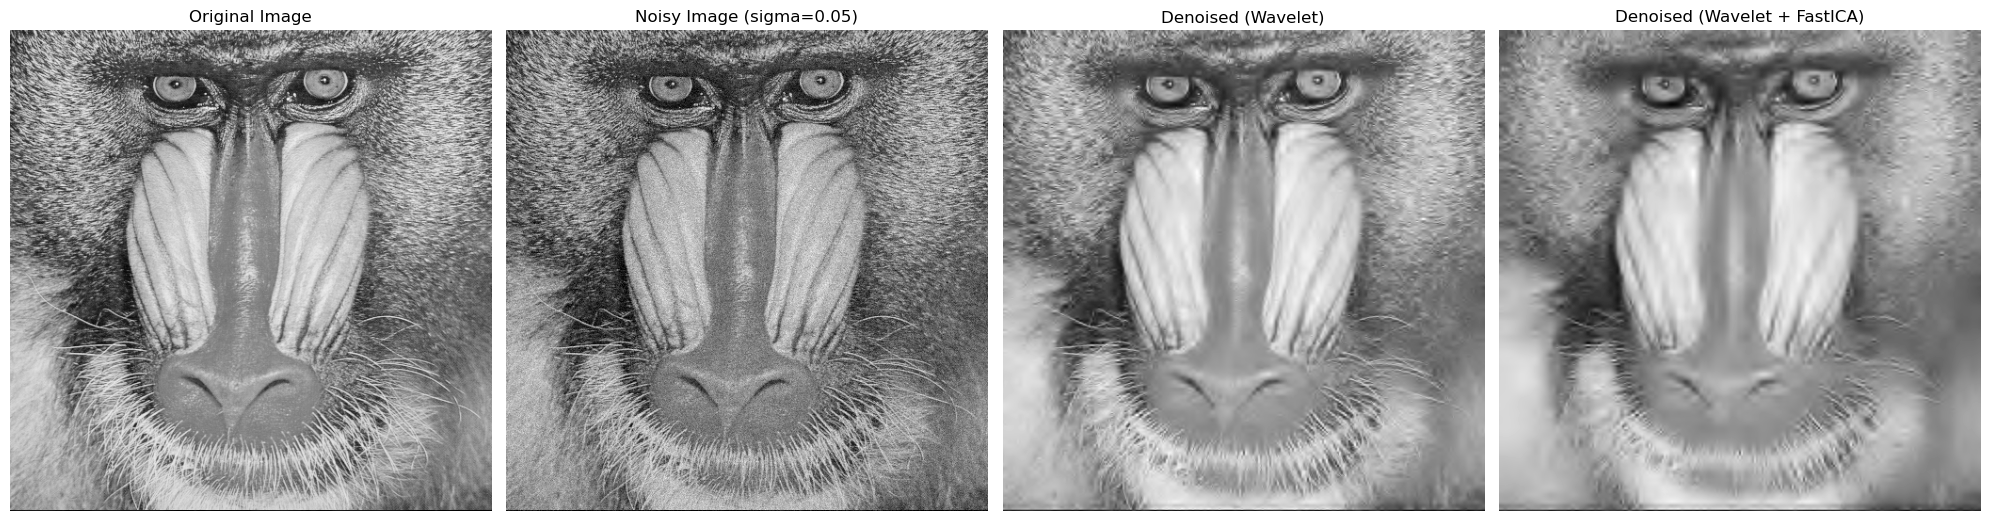

In [519]:
import numpy as np
import pywt
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from PIL import Image

# Fonction pour ajouter du bruit à une image
def add_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 1)

# Fonction de seuillage doux amélioré
def soft_threshold(coeff, threshold):
    return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

# Fonction pour ajuster dynamiquement les seuils en fonction des niveaux d'ondelette
def adaptive_threshold(coeffs, sigma, N):
    thresholds = []
    for i, coeff in enumerate(coeffs):
        # Ajustement dynamique du seuil
        threshold = (np.log(N) + 2**(i - 1)) / np.sqrt(2 * np.log(N)) * sigma
        thresholds.append(threshold)
    return thresholds

# Fonction de débruitage par Ondelette Dyadique
def wavelet_denoising(image, wavelet='db4', level=5, sigma=0.1):
    # Décomposition en ondelettes dyadiques
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Calcul des seuils dynamiques
    N = image.size
    thresholds = adaptive_threshold(coeffs[1:], sigma, N)
    
    # Appliquer le seuillage doux sur les coefficients haute fréquence
    denoised_coeffs = [coeffs[0]]  # Garder les approximations basses fréquences
    for i, (cH, cV, cD) in enumerate(coeffs[1:]):
        threshold = thresholds[i]
        cH = soft_threshold(cH, threshold)
        cV = soft_threshold(cV, threshold)
        cD = soft_threshold(cD, threshold)
        denoised_coeffs.append((cH, cV, cD))
    
    # Reconstruction de l'image
    denoised_image = pywt.waverec2(denoised_coeffs, wavelet)
    return np.clip(denoised_image, 0, 1)

# Fonction pour appliquer FastICA
def fast_ica_denoising(image, components=1):
    # Aplatir l'image pour appliquer FastICA
    h, w = image.shape
    image_flat = image.flatten().reshape(-1, 1)
    
    # FastICA
    ica = FastICA(n_components=components, max_iter=1000, tol=1e-4)
    ica_transformed = ica.fit_transform(image_flat)
    reconstructed = ica.inverse_transform(ica_transformed).reshape(h, w)
    
    return np.clip(reconstructed, 0, 1)

# Pipeline complet : Ondelette + FastICA
def wavelet_ica_denoising(image, wavelet='db4', level=5, sigma=0.1, ica_components=1):
    # Étape 1 : Débruitage par ondelettes dyadiques
    denoised_wavelet = wavelet_denoising(image, wavelet=wavelet, level=level, sigma=sigma)
    
    # Étape 2 : Débruitage par FastICA
    denoised_wavelet_ica = fast_ica_denoising(denoised_wavelet, components=ica_components)
    
    return denoised_wavelet_ica

# Charger l'image originale
image_path = 'images/baboon.png'
image_original = Image.open(image_path).convert("L")  # Convertir en niveaux de gris
image_original = np.array(image_original) / 255.0  # Normaliser entre [0, 1]

# Ajouter du bruit à l'image
sigma_noise = 0.05
image_noisy = add_noise(image_original, sigma_noise)

# Appliquer le pipeline de débruitage
denoised_wavelet = wavelet_denoising(image_noisy, wavelet='db4', level=5, sigma=sigma_noise)
denoised_wavelet_ica = wavelet_ica_denoising(denoised_wavelet, wavelet='db4', level=5, sigma=sigma_noise, ica_components=1)

# Afficher les résultats
plt.figure(figsize=(20, 10))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(image_original, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Image bruitée
plt.subplot(1, 4, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f"Noisy Image (sigma={sigma_noise})")
plt.axis('off')

# Image débruitée avec Ondelette
plt.subplot(1, 4, 3)
plt.imshow(denoised_wavelet, cmap='gray')
plt.title("Denoised (Wavelet)")
plt.axis('off')

# Image débruitée avec Ondelette + FastICA
plt.subplot(1, 4, 4)
plt.imshow(denoised_wavelet_ica, cmap='gray')
plt.title("Denoised (Wavelet + FastICA)")
plt.axis('off')

plt.tight_layout()
plt.show()


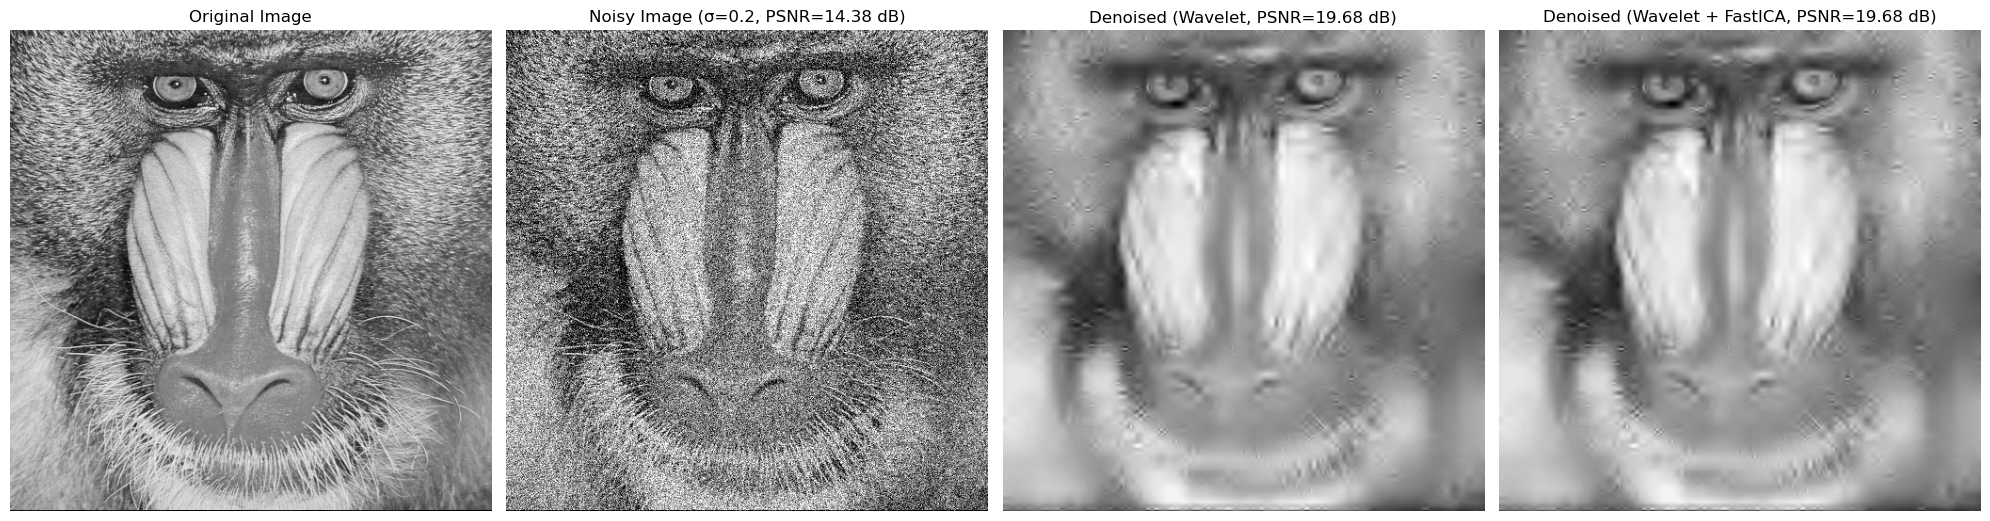

In [520]:
import numpy as np
import pywt
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from PIL import Image

# Function to add noise to an image
def add_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 1)

# Function for soft thresholding
def soft_threshold(coeff, threshold):
    return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

# Function for dynamic threshold adjustment
def adaptive_threshold(coeffs, sigma, N):
    thresholds = []
    for i, coeff in enumerate(coeffs):
        # Dynamic threshold adjustment
        threshold = (np.log(N) + 2**(i - 1)) / np.sqrt(2 * np.log(N)) * sigma
        thresholds.append(threshold)
    return thresholds

# Function for wavelet denoising
def wavelet_denoising(image, wavelet='db4', level=5, sigma=0.1):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    N = image.size
    thresholds = adaptive_threshold(coeffs[1:], sigma, N)
    denoised_coeffs = [coeffs[0]]
    for i, (cH, cV, cD) in enumerate(coeffs[1:]):
        threshold = thresholds[i]
        cH = soft_threshold(cH, threshold)
        cV = soft_threshold(cV, threshold)
        cD = soft_threshold(cD, threshold)
        denoised_coeffs.append((cH, cV, cD))
    return np.clip(pywt.waverec2(denoised_coeffs, wavelet), 0, 1)

# Function for FastICA
def fast_ica_denoising(image, components=1):
    h, w = image.shape
    image_flat = image.flatten().reshape(-1, 1)
    ica = FastICA(n_components=components, max_iter=1000, tol=1e-4)
    ica_transformed = ica.fit_transform(image_flat)
    reconstructed = ica.inverse_transform(ica_transformed).reshape(h, w)
    return np.clip(reconstructed, 0, 1)

# Function for full pipeline: Wavelet + FastICA
def wavelet_ica_denoising(image, wavelet='db4', level=5, sigma=0.1, ica_components=1):
    denoised_wavelet = wavelet_denoising(image, wavelet=wavelet, level=level, sigma=sigma)
    denoised_wavelet_ica = fast_ica_denoising(denoised_wavelet, components=ica_components)
    return denoised_wavelet_ica

# Function to calculate PSNR
def psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100  # Images are identical
    max_pixel = 1.0  # Assuming image is normalized to [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Load the original image
image_path = 'images/baboon.png'
image_original = Image.open(image_path).convert("L")  # Convert to grayscale
image_original = np.array(image_original) / 255.0  # Normalize to [0, 1]

# Add noise to the image
sigma_noise = 0.2
image_noisy = add_noise(image_original, sigma_noise)

# Apply the denoising pipelines
denoised_wavelet = wavelet_denoising(image_noisy, wavelet='db4', level=5, sigma=sigma_noise)
denoised_wavelet_ica = wavelet_ica_denoising(image_noisy, wavelet='db4', level=5, sigma=sigma_noise, ica_components=1)

# Calculate PSNR values
psnr_noisy = psnr(image_original, image_noisy)
psnr_wavelet = psnr(image_original, denoised_wavelet)
psnr_wavelet_ica = psnr(image_original, denoised_wavelet_ica)

# Display the results with PSNR values
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image_original, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Noisy image
plt.subplot(1, 4, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f"Noisy Image (\u03c3={sigma_noise}, PSNR={psnr_noisy:.2f} dB)")
plt.axis('off')

# Denoised image (Wavelet)
plt.subplot(1, 4, 3)
plt.imshow(denoised_wavelet, cmap='gray')
plt.title(f"Denoised (Wavelet, PSNR={psnr_wavelet:.2f} dB)")
plt.axis('off')

# Denoised image (Wavelet + FastICA)
plt.subplot(1, 4, 4)
plt.imshow(denoised_wavelet_ica, cmap='gray')
plt.title(f"Denoised (Wavelet + FastICA, PSNR={psnr_wavelet_ica:.2f} dB)")
plt.axis('off')

plt.tight_layout()
plt.show()


/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:595: UserWarni

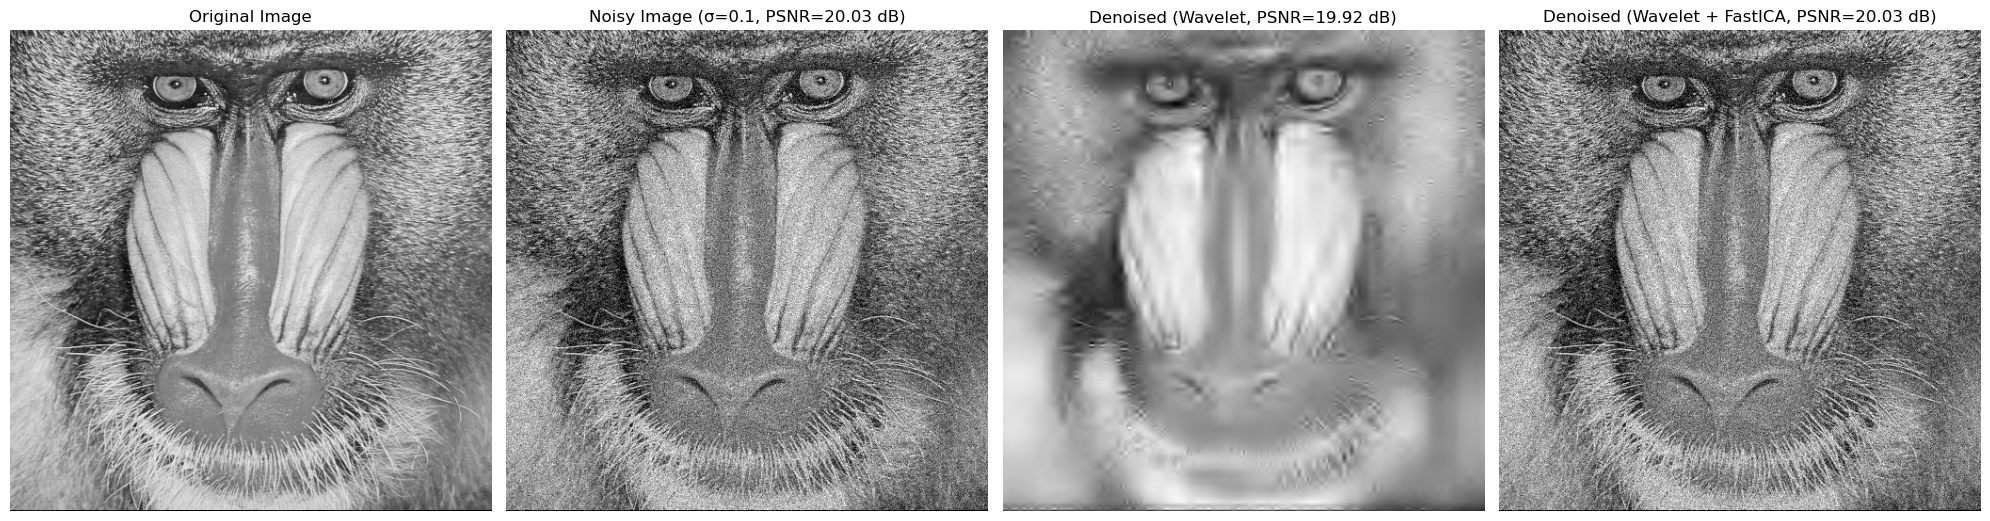

In [ ]:
import numpy as np
import pywt
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from PIL import Image

# Function to add noise to an image
def add_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 1)

# Function for soft thresholding
def soft_threshold(coeff, threshold):
    return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

# Function for wavelet denoising
def wavelet_denoising(image, wavelet='db4', level=5, sigma=0.1):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    denoised_coeffs = [coeffs[0]]
    for i, (cH, cV, cD) in enumerate(coeffs[1:]):
        threshold = sigma * np.sqrt(2 * np.log(image.size))
        cH = soft_threshold(cH, threshold)
        cV = soft_threshold(cV, threshold)
        cD = soft_threshold(cD, threshold)
        denoised_coeffs.append((cH, cV, cD))
    return np.clip(pywt.waverec2(denoised_coeffs, wavelet), 0, 1)

# Function for ICA denoising
def ica_denoising(coeffs, components=1):
    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for cH, cV, cD in coeffs[1:]:
        # Apply ICA on each sub-band (high-frequency details)
        ica = FastICA(n_components=components, max_iter=1000, tol=1e-4)
        cH_flat = cH.flatten().reshape(-1, 1)
        cV_flat = cV.flatten().reshape(-1, 1)
        cD_flat = cD.flatten().reshape(-1, 1)

        cH_denoised = ica.inverse_transform(ica.fit_transform(cH_flat)).reshape(cH.shape)
        cV_denoised = ica.inverse_transform(ica.fit_transform(cV_flat)).reshape(cV.shape)
        cD_denoised = ica.inverse_transform(ica.fit_transform(cD_flat)).reshape(cD.shape)

        denoised_coeffs.append((cH_denoised, cV_denoised, cD_denoised))
    return denoised_coeffs

# Function combining wavelet and ICA denoising
def wavelet_ica_denoising(image, wavelet='db4', level=5, ica_components=1):
    # Wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Apply ICA on high-frequency coefficients
    denoised_coeffs = ica_denoising(coeffs, components=ica_components)

    # Reconstruct the image from denoised coefficients
    return np.clip(pywt.waverec2(denoised_coeffs, wavelet), 0, 1)

# Function to calculate PSNR
def psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100  # Images are identical
    max_pixel = 1.0  # Assuming image is normalized to [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Load the original image
image_path = 'images/baboon.png'
image_original = Image.open(image_path).convert("L")  # Convert to grayscale
image_original = np.array(image_original) / 255.0  # Normalize to [0, 1]

# Add noise to the image
sigma_noise = 0.1
image_noisy = add_noise(image_original, sigma_noise)

# Apply the denoising pipelines
denoised_wavelet = wavelet_denoising(image_noisy, wavelet='db4', level=5)
denoised_wavelet_ica = wavelet_ica_denoising(image_noisy, wavelet='db4', level=5, ica_components=2)

# Calculate PSNR values
psnr_noisy = psnr(image_original, image_noisy)
psnr_wavelet = psnr(image_original, denoised_wavelet)
psnr_wavelet_ica = psnr(image_original, denoised_wavelet_ica)

# Display the results with PSNR values
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image_original, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Noisy image
plt.subplot(1, 4, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f"Noisy Image (\u03c3={sigma_noise}, PSNR={psnr_noisy:.2f} dB)")
plt.axis('off')

# Denoised image (Wavelet)
plt.subplot(1, 4, 3)
plt.imshow(denoised_wavelet, cmap='gray')
plt.title(f"Denoised (Wavelet, PSNR={psnr_wavelet:.2f} dB)")
plt.axis('off')

# Denoised image (Wavelet + FastICA)
plt.subplot(1, 4, 4)
plt.imshow(denoised_wavelet_ica, cmap='gray')
plt.title(f"Denoised (Wavelet + FastICA, PSNR={psnr_wavelet_ica:.2f} dB)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Image compression


/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/sklearn/decomp

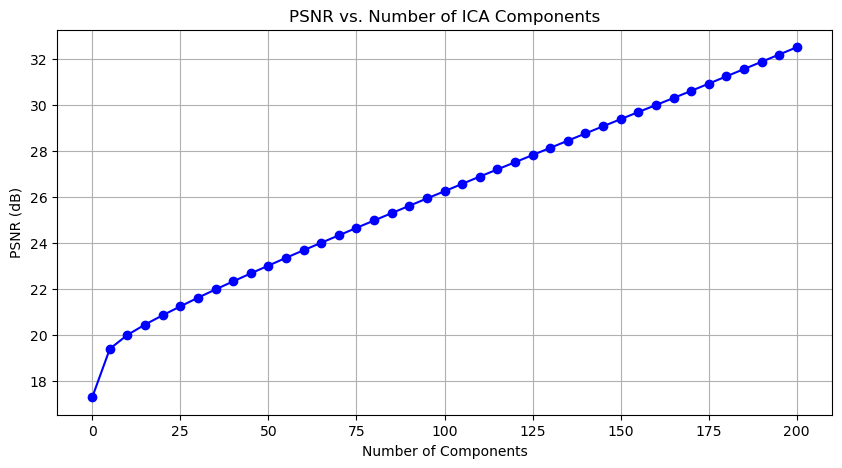

In [618]:
image = Image.open('images/baboon.png').convert('L')
image = np.array(image) / 255.0
components = np.arange(0, 205, 5)
psnr_values = np.zeros_like(components, dtype=np.float64)

for component in components:
    ica = sk_FastICA(n_components=component+1)
    image_ica = ica.fit_transform(image)
    image_reconstructed = ica.inverse_transform(image_ica)
    psnr_value = Metrics.psnr(image, image_reconstructed)
    psnr_values[component // 5] = psnr_value

plt.figure(figsize=(10, 5))
plt.plot(components, psnr_values, marker='o', color='blue')
plt.title('PSNR vs. Number of ICA Components')
plt.xlabel('Number of Components')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()
